In [5]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import utils
import tensorflow_datasets as tfds

In [6]:
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # 40% for training, 10% for validation, and 10% for test (the rest unused)
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


In [7]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

In [8]:
from tensorflow import data as tf_data
batch_size = 64

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

2024-03-01 21:39:31.474582: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


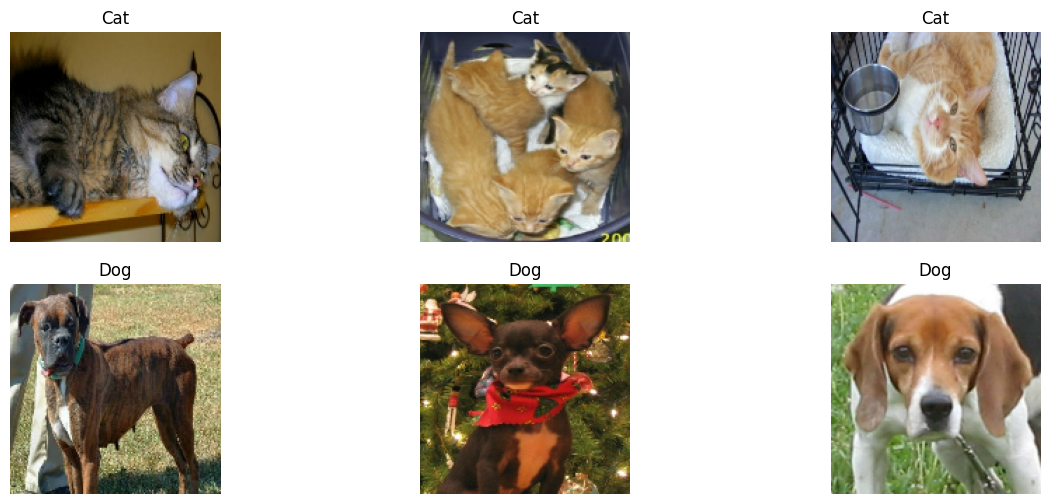

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_dataset(dataset, num_samples=3, title=""):
    
    plt.figure(figsize=(15, 6))

    # initialize empty sets for each animal
    cat_images, dog_images = [], []
    #for loop to iterate through each image in the dataset
    for images, labels in dataset.take(1):
        for image, label in zip(images, labels):
            if label == 0:
                cat_images.append(image.numpy())
            else:
                dog_images.append(image.numpy())

    for i in range(num_samples):
        # Plot cat images in the first row
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(cat_images[i].astype("uint8"))
        plt.title("Cat")
        plt.axis("off")

        # Plot dog images in the second row
        plt.subplot(2, num_samples, i + num_samples + 1)
        plt.imshow(dog_images[i].astype("uint8"))
        plt.title("Dog")
        plt.axis("off")

    plt.show()



visualize_dataset(train_ds, title="Random Samples from Training Dataset")

In [10]:
labels_iterator= train_ds.unbatch().map(lambda image, label: label).as_numpy_iterator()

cat_count = 0
dog_count = 0

# Iterate through labels
for label in labels_iterator:
    if label == 0:
        cat_count += 1
    elif label == 1:
        dog_count += 1

print("Number of images with label 0 (cat):", cat_count)
print("Number of images with label 1 (dog):", dog_count)

Number of images with label 0 (cat): 4637
Number of images with label 1 (dog): 4668


In [11]:
import tensorflow as tf
from tensorflow.keras import layers

model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model1.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

history = model1.fit(train_ds, 
                     epochs=20, 
                     validation_data=validation_ds)

Epoch 1/20
146/146 [==============================] - 796s 5s/step - loss: 16.5267 - accuracy: 0.5349 - val_loss: 0.6915 - val_accuracy: 0.5077
Epoch 2/20
146/146 [==============================] - 311s 2s/step - loss: 0.6851 - accuracy: 0.5463 - val_loss: 0.6899 - val_accuracy: 0.5159
Epoch 3/20
146/146 [==============================] - 301s 2s/step - loss: 0.6778 - accuracy: 0.5509 - val_loss: 0.6903 - val_accuracy: 0.5404
Epoch 4/20
146/146 [==============================] - 7084s 49s/step - loss: 0.6722 - accuracy: 0.5549 - val_loss: 0.6993 - val_accuracy: 0.5215
Epoch 5/20
146/146 [==============================] - 6544s 45s/step - loss: 0.6659 - accuracy: 0.5631 - val_loss: 0.7132 - val_accuracy: 0.5396
Epoch 6/20
146/146 [==============================] - 6102s 42s/step - loss: 0.6545 - accuracy: 0.5768 - val_loss: 0.9376 - val_accuracy: 0.5456
Epoch 7/20
146/146 [==============================] - 17919s 124s/step - loss: 0.6651 - accuracy: 0.5703 - val_loss: 0.7773 - val_accur

Some things I experimented with was increasing the model complexity by adding more layers. Additionally, I tried to regularized the data to prevent overfitting.

**The accuracy of my model stabilized between 60% and 61% during training, which is higher than the baseline.**

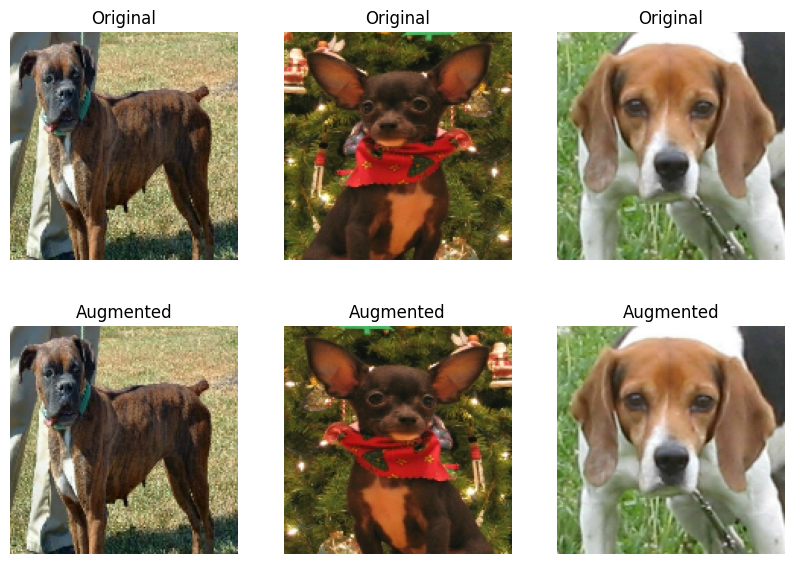

In [46]:
#random_flip_layer
import matplotlib.pyplot as plt
import tensorflow as tf

# Load a few sample images
sample_images = []
for image, label in train_ds.take(1):
    sample_images = image.numpy()[:4]  # Take the first three images

# Normalize pixel values to the range [0, 1]
sample_images = sample_images.astype("float32") / 255.0

# Create a RandomFlip layer
random_flip_layer = tf.keras.layers.RandomFlip("horizontal")

# Apply RandomFlip to the sample images
augmented_images = random_flip_layer(sample_images)

# Plot original and augmented images
plt.figure(figsize=(10, 7))
for i in range(0, 3):
    # Original image
    plt.subplot(2, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.title("Original")
    plt.axis("off")

    # Augmented image
    plt.subplot(2, 3, i + 4)
    plt.imshow(augmented_images[i])
    plt.title("Augmented")
    plt.axis("off")

plt.show()

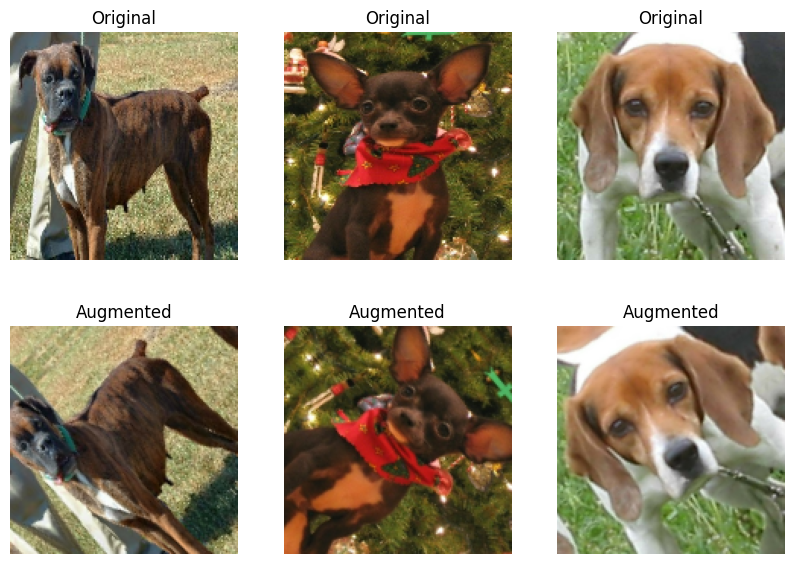

In [47]:
#RandomRotation layer

sample_images = []
for image, label in train_ds.take(1):
    sample_images = image.numpy()[:3]  # Take the first three images

# Normalize pixel values to the range [0, 1]
sample_images = sample_images.astype("float32") / 255.0

# Create a RandomRotation layer
random_rotation_layer = tf.keras.layers.RandomRotation(factor=0.2)

# Apply RandomRotation to the sample images
augmented_images = random_rotation_layer(sample_images)

# Plot original and augmented images
plt.figure(figsize=(10, 7))
for i in range(0, 3):
    # Original image
    plt.subplot(2, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.title("Original")
    plt.axis("off")

    # Augmented image
    plt.subplot(2, 3, i + 4)
    plt.imshow(augmented_images[i])
    plt.title("Augmented")
    plt.axis("off")

plt.show()

In [12]:
#creating model2 with augmentation layers
import tensorflow as tf

model2 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(factor=0.2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model2
model2.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

# Train model2
history2 = model2.fit(train_ds, 
                      epochs=20, 
                      validation_data=validation_ds)

Epoch 1/20
146/146 [==============================] - 57s 380ms/step - loss: 17.7128 - accuracy: 0.5332 - val_loss: 0.6922 - val_accuracy: 0.5318
Epoch 2/20
146/146 [==============================] - 55s 374ms/step - loss: 0.6911 - accuracy: 0.5413 - val_loss: 0.6842 - val_accuracy: 0.5318
Epoch 3/20
146/146 [==============================] - 62s 424ms/step - loss: 0.6857 - accuracy: 0.5487 - val_loss: 0.6976 - val_accuracy: 0.5632
Epoch 4/20
146/146 [==============================] - 59s 400ms/step - loss: 0.6881 - accuracy: 0.5510 - val_loss: 0.6820 - val_accuracy: 0.5482
Epoch 5/20
146/146 [==============================] - 60s 408ms/step - loss: 0.6822 - accuracy: 0.5650 - val_loss: 0.6842 - val_accuracy: 0.5610
Epoch 6/20
146/146 [==============================] - 68s 469ms/step - loss: 0.6776 - accuracy: 0.5642 - val_loss: 0.6776 - val_accuracy: 0.5942
Epoch 7/20
146/146 [==============================] - 72s 493ms/step - loss: 0.6778 - accuracy: 0.5792 - val_loss: 0.6640 - val_a

**The accuracy of my model stabilized between 67% and 68% during training, which is a bit higher than in model1, and still higher than 60%.**

In model2, if the accuracy stabilized around 67% to 68% during training and the validation accuracy closely tracked the training accuracy without diverging significantly, it indicates that the model may not be overfitting. Signs of overfitting include a large gap between training and validation accuracy or when the validation accuracy starts decreasing while the training accuracy continues to increase.

In [ ]:
i = keras.Input(shape=(150, 150, 3))
# The pixel values have the range of (0, 255), but many models will work better if rescaled to (-1, 1.)
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(i)
preprocessor = keras.Model(inputs = [i], outputs = [x])

model3 = tf.keras.Sequential([
    preprocessor,
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(factor=0.2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model3
model3.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

history3 = model3.fit(train_ds, 
                      epochs=20,  # Increase the number of epochs
                      validation_data=validation_ds)


Epoch 1/20
146/146 [==============================] - 67s 457ms/step - loss: 0.7210 - accuracy: 0.5858 - val_loss: 0.6191 - val_accuracy: 0.6711
Epoch 2/20
146/146 [==============================] - 70s 480ms/step - loss: 0.6104 - accuracy: 0.6658 - val_loss: 0.5374 - val_accuracy: 0.7270
Epoch 3/20
146/146 [==============================] - 71s 485ms/step - loss: 0.5784 - accuracy: 0.6925 - val_loss: 0.5242 - val_accuracy: 0.7360
Epoch 4/20
146/146 [==============================] - 70s 476ms/step - loss: 0.5514 - accuracy: 0.7200 - val_loss: 0.5132 - val_accuracy: 0.7463
Epoch 5/20
146/146 [==============================] - 72s 490ms/step - loss: 0.5294 - accuracy: 0.7385 - val_loss: 0.4864 - val_accuracy: 0.7610
Epoch 6/20
146/146 [==============================] - 74s 506ms/step - loss: 0.5149 - accuracy: 0.7480 - val_loss: 0.4862 - val_accuracy: 0.7734
Epoch 7/20
146/146 [==============================] - 77s 527ms/step - loss: 0.5093 - accuracy: 0.7534 - val_loss: 0.4776 - val_ac

**The validation accuracy stabilized between 80% and 82% during training**
This is much higher than the val_accuracy of model1, which was ~60%.

Since there is not a significant gap between the training and validation accuracy, it suggests that model3 is not overfitting the data.

In [56]:
IMG_SHAPE = (150, 150, 3)
base_model = keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)
weights_path = "/Users/andrewhan/Desktop/2023-2024/Winter_24/PIC_Class/Homework/HW5/weights_mobilenet_v3_large_224_1.0_float_no_top_v2.h5"
base_model.load_weights(weights_path)

base_model.trainable = False

i = keras.Input(shape=IMG_SHAPE)
x = base_model(i, training = False)
base_model_layer = keras.Model(inputs = i, outputs = x)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(factor=0.2)
])

model4 = tf.keras.Sequential([
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')  
])

model4.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

history4 = model4.fit(train_ds, 
                      epochs=20,  # Increase the number of epochs
                      validation_data=validation_ds)


Epoch 1/20
146/146 [==============================] - 47s 301ms/step - loss: 0.2480 - accuracy: 0.8884 - val_loss: 0.0831 - val_accuracy: 0.9703
Epoch 2/20
146/146 [==============================] - 39s 264ms/step - loss: 0.1343 - accuracy: 0.9469 - val_loss: 0.0740 - val_accuracy: 0.9695
Epoch 3/20
146/146 [==============================] - 41s 283ms/step - loss: 0.1173 - accuracy: 0.9533 - val_loss: 0.0699 - val_accuracy: 0.9712
Epoch 4/20
146/146 [==============================] - 40s 272ms/step - loss: 0.1158 - accuracy: 0.9540 - val_loss: 0.0728 - val_accuracy: 0.9716
Epoch 5/20
146/146 [==============================] - 38s 257ms/step - loss: 0.1127 - accuracy: 0.9563 - val_loss: 0.0647 - val_accuracy: 0.9751
Epoch 6/20
146/146 [==============================] - 38s 264ms/step - loss: 0.1106 - accuracy: 0.9552 - val_loss: 0.0661 - val_accuracy: 0.9733
Epoch 7/20
146/146 [==============================] - 39s 264ms/step - loss: 0.1011 - accuracy: 0.9594 - val_loss: 0.0642 - val_ac

**The model4 validation accuracy stabilzed between 97% and 98%, which is greater than the required 93%**
This val_accuracy is also much higher than from model1, which was around 60%.

There does not seem to be any overfitting as there is not much difference between the test and validation accuracy.

In [58]:
test_loss, test_accuracy = model4.evaluate(test_ds)

# Print the test accuracy
print(f'Test accuracy: {test_accuracy}')

37/37 [==============================] - 7s 186ms/step - loss: 0.0733 - accuracy: 0.9729
Test accuracy: 0.9729148745536804


# The test accuracy was over 97%, so we can see that the model works well.
This suggests that the model has effectively learned to distinguish between cats and dogs in the test dataset.